In [1]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra
using StatsBase

In [3]:
mutable struct Particle
    pose
    weight
end

In [4]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [5]:
function observation_update(self::Particle, observation, envmap, distance_dev_rate, direction_dev)
#     print(observation)
    for d in observation
        obs_pos = d[1]
        obs_id = d[2]+1#1-indexed in julia
        
        pos_on_map = envmap.landmarks[obs_id].pos
        particle_suggest_pos = relative_polar_pos(IdealCamera(), self.pose, pos_on_map)
        
        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = Diagonal([distance_dev^2, direction_dev^2])
        self.weight *= pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

observation_update (generic function with 1 method)

In [6]:
mutable struct Mcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
end

In [26]:
function Mcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                        distance_dev_rate=0.14, direction_dev=0.05)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    return self
end

Mcl_ (generic function with 4 methods)

In [27]:
function set_ml(self::Mcl)
    i = argmax([p.weight for p in self.particles])
    self.ml = self.particles[i]
    self.pose = self.ml.pose
end

set_ml (generic function with 1 method)

In [28]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [29]:
function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling(self)
end

observation_update (generic function with 2 methods)

In [30]:
rand(Uniform(0,10))

6.284985502338472

In [31]:
x = []
append!(x, 1)

1-element Array{Any,1}:
 1

In [32]:
function resampling(self::Mcl)
    ws = cumsum([e.weight for e in self.particles])
    if ws[end] < 1e-100
        ws = [e+1e-100 for e in ws]
    end
    step = ws[end]/length(self.particles)
    r = rand(Uniform(0.0, step))
    cur_pos = 1
    ps = []
    while (length(ps) < length(self.particles))
        if r < ws[cur_pos]
            push!(ps, self.particles[cur_pos])
            r += step
        else
            cur_pos += 1
#             if cur_pos > length(self.particles)
#                 cur_pos = 1
#             end
        end
        
    end
    self.particles = [deepcopy(e) for e in ps]
    for p in self.particles
        p.weight = 1.0/length(self.particles)
    end
end

resampling (generic function with 1 method)

In [33]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
end

draw (generic function with 7 methods)

In [34]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [35]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [36]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [38]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
    x,y,t = self.estimator.pose
    s = @sprintf("(%.2f, %.2f, %d)", x, y, Int(round(t*180/pi))%360)
    vcat(elems, ax.text(x, y+0.1, s, fontsize=8))
end

draw (generic function with 7 methods)

In [39]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAzzptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGaVliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3CimocEIxgWHhcXsc0ItOim0ez6RJjKYdkExkbDNWNFqekX8N/NJdrhHf4bNYpJWcXLaKUNrMHhvqXZJ+SwcJ6mFfPwNPLrJv+DDpY4SVqL5R/ZIi7P6pStshU8l8YE20635mxTsHD65d2Y7EWqBRNOFvBvVWpop73HJx3MG9dDO8IN0M3HIea4NsKY55jVZygb63BcFTTjTTan0pGHRWhTT8v9IxaHKXGKj49JGIGLu7t9H2DumHqliyxeQyVT3QcD6QRFLbAHUwkx4eRLq2Vo6oTMp0CFGZgwRc8oI43kXL+DNPiMqqAZKCt/QKDVb1eJ3jQKKXaBeak6zFs0zXDvqKKnCv1G8LUDrg6cbKFsIV7Ct6+Gd7BDubN9u1BI8ywu9ZaPgejZYZVgUDTySa+CyiYF5GeVwiRt/ZrQ3rXokTAh9m6cvHktkQkKj6HJeSAfCFRbXXQyXFltEMSL8TbEv5W9pq/b597ZTqCEYEMp4Lq9ZFzK35p8m1oU4jI9SA/qeyBwUMj5oTrBiSI4jmgF2VnNRAWpJaNgBsuPjsu+IRnIePaR4rQ2fk6IMv7c8/Y6/HVRT12fvD66SM7BytUrwT5gk9byxj/gkh8hKSX+wTR0oZJS8t78rON+9SXxnpkosDKbbqCV5bCZMPagN7X0izsPnhsad8fo71sRP46RSTOhDTBrsZv6sEbOU8JKbE7EvOmqPDMfuf5rlQ6tUSmRzSWkBjW3tqDWw0toYkujqG2QvB1j3tGKx/IdI5HSQUJmYhUqOSDPhSAFEnQVoQ+W/09DvcVXNYTf/otngNW+alaFlocZ5MNujUBbaeNzDkHO61hf9OetSfhJDYyAEVMyGt5BBDG4nLB9ciqmJcKuT97qCgjcM9evohEanf3Yewd6TEGmejnjS+peFtDP00f8tcC5x+Lj8vloMsc6tFB6cKOn5nIEjH/QNT1gpX+2gXkwFyI1TMmlhFgU3RRKuahxNm3BawNjx7WGY9VldfnmjK9sXb9wv8TtRNRK5I+AdvJMu1JYUmKXx9SdN53f7ypb0JUb38SrJLdCzs07SQMRvD9pOKxm+eoQd9PgDOU4ZWbymYT0CqgR8tRkYhiHLWhMuNGNbI3Wj316An3X2l9tZ3i1803qwEVwf5o7kDOgZhFTBuYraqgz5PUVOeAuvtZu/arJWVfq578ybMXqdEXSm98yAaiUUzC25/MpZDtsIjev47KWkOq/yaVxjaE1GTqR1cOTLlWa4z0RgY5JvKQa4sy5orracAqbaPKwJiL3OECNN/gVFX2yjFSrdkaDijzNNafxkp5oTcdRumkmMwBHBBoZwxC9NXDNUlypdTTCTMnX+br/AoPxhca5ZvedGdRo1PjiX3MSrf2+hSK7ZUnF9cXnJUR7dH0hpsbJ0QKxBA+krHjT0jJv4dgSV0e1zV1aBzUKdX/OS78BurPuUSoLz1fV8zTPFrtBRkt9Tf6+iXsX6gvCH6W4O7iGQnDjlILFhJqGA/a3bFD1BA2CYnak32WJzTtzjwmb36yN3IAR/8bBWA3dmMnFawJQh89jDOX7ipd35Aq8Nxf5MbqC/ShLn6e0juXKGjA8sM6rykLpnAe+bmJtdRo6S9na78r4N8halFjjMuQTQjS9HsGvQT6DKCIgsFYSU3epbScQGocMpefQKYYeKO1KxPJ5IYc5kLexhOexHiIyTAE4hZzmmMAnXMqxhOhLV7VIOQHtjK1ohuP/iUcTQzkqd1E6bFPU840X/af6JiZZr+37bb4dnWZUjyQxQYUxEca7Xim3+XP59GiTLy1U8VmkQ1QeDBF++HClSin2zyHxXXJA+MUFfaSjiq7/EReefMJes7xyIu9iVQIMiJGZi/FHaH00iPsQaJ46J+T7o6JbAT0BvyOVR+gG3o/8AaIKaQR

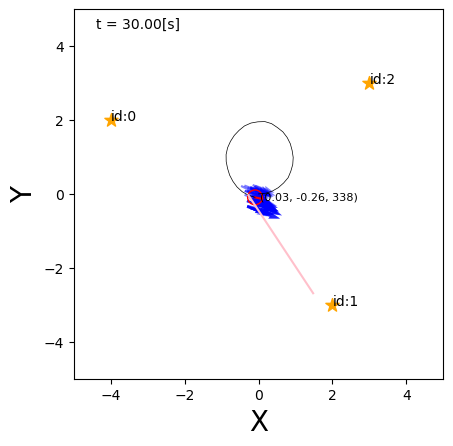

In [40]:
trial()